# <center>Almgren and Chriss Model</center>

The model of Almgren and Chriss is often used in the context of quantitative portfolio management, where it can be used to optimize trades based on the impact they will have on asset prices.   
Let us consider a quantity X to be liquidated in increments $n_1…n_k$ with $x_k$ quantity which remains to be liquidated. We want everything to be sold at t=T.

**<u>Permanent market impact</u>** :
Refers to the long-term change in the market price of an asset resulting from a trade. This is the portion of the market impact that persists even after the trade has been completed. Therefore, the "equilibrum price" of the asset is modified in a permanent way:

$$S_k=S_{k-1}+\sigma \sqrt{\tau} \epsilon_k -\tau g(n_k/\tau)$$

**<u>Temporary market impact</u>** :
Refers to the short-term change in the price of an asset that is caused by the presence of the trade in the market. This is the portion of the market impact that disappears once the trade has been completed. Temporary market impact is typically associated with the transaction costs (difference between the bid and the ask price):

$$\overline{S_k}=S_{k-1}-h(n_k/\tau)$$

**<u>Cost of Trading</u>** :

The result of the sell of the asset is :

$$\sum\limits_{k=1} ^{N}n_k\overline{S_k}=XS_0+\sum\limits_{k=1} ^{N}(\sigma \sqrt{\tau} \epsilon_k -\tau g(n_k/\tau))x_k -\sum\limits_{k=1} ^{N}n_k h(n_k/\tau)$$

$XS_0$ represents what we were hoping to gain if we didn't have other costs.  
We define the trading cost as : $C=XS_0-\sum\limits_{k=1} ^{N}n_k \overline{S_k}$

In the Almgren-Chriss model, both permanent and temporary market impact are taken into account when computing the optimal trade execution strategy. By minimizing both types of market impact, a trader can minimize the cost of executing a trade.
So we will look for strategies minimizing :

$$E[C]+\lambda V[C]$$

with:  

$$E(C)=\sum\limits _{k=1} ^{N}[\tau x_k g(\frac{n_k}{\tau})+n_k h(\frac{n_k}{\tau})]$$

$$V(C)=\sigma^2\sum\limits _{k=1} ^{N}\tau x_k^2$$

$$\lambda : \text{risk aversion parameter}$$    


**<u>Hypothèse d'Almgren et Chriss</u> : Impact Linéaire** : 

$$\sum\limits _{k=1} ^{N}\tau x_k g(\frac{n_k}{\tau})=\frac{1}{2}\gamma X^2-\frac{1}{2}\gamma \sum\limits _{k=1} ^{N} n_k^2 $$

$$n_k h(\frac{n_k}{\tau})=\xi \left|{n_k}\right|+\frac{\eta n_k^2}{\tau}$$     

So $$E[C]+\lambda V[C]=\frac{1}{2}\gamma X^2 -\frac{1}{2}\gamma\sum\limits _{k=1} ^{N}n_k^2+\xi \sum\limits _{k=1} ^{N}\left| n_k \right|+\frac{\eta}{\tau}\sum\limits _{k=1} ^{N}n_k^2$$  

with : $\xi$ half of the bid-ask spread. 

**<u>Optimal Strategies</u>** :
$$x_k=\frac{\sinh(\kappa(T-k\tau))}{\sinh(\kappa T)}X$$  

with :

$$\kappa=\sqrt{\frac{\lambda\sigma^2}{\eta}}$$  


**<u>Other parameters</u>** :

$$\eta=\frac{Spread}{0.01\times \text{Daily Volume}}$$

$$\gamma=\frac{Spread}{0.1\times \text{Daily Volume}}$$


In [3]:
import numpy as np
import matplotlib.pyplot as plt

#xk : quantité qu'il reste à liquider
def x(k, kappa, T, tau, X):
    numerator = np.sinh(kappa*(T-(k*tau)))*X   
    denominator = np.sinh(kappa*T)
    return(numerator/denominator)

#nk : quantité déja liquidé
def n(X,k,kappa,T,tau):
    return X-x(k, kappa, T, tau, X)
    
#Espérance
def E(df, N, tau, gamma, eta,X,kappa,T): #risque de liquidité
    e=df['spread'].mean()/2
    somme_nk2 = 0
    somme_nk=0
    for k in range (1,N):
        somme_nk2 = somme_nk2 + pow(n(X,k,kappa,T,tau),2)
        somme_nk=somme_nk+abs(n(X,k,kappa,T,tau))
    return 0.5*gamma*pow(X,2)+e*somme_nk+(eta*somme_nk2/tau)-0.5*gamma*somme_nk2

#Variance 
def V (var,tau,X,T,kappa): #risque de marché 
    somme = 0
    for k in range (1,N):
        somme = somme + pow(x(k, kappa, T, tau, X),2)
    return var*somme*tau


In [8]:
#main
import pandas as pd
df= pd.read_excel('Data.xlsx',header=0,names=['date', 'spread','volume','sign','price'])

#Paramètres
X=500 #1000 10000 #quantité à liquider
T = 1
N = 24
tau = T/N 
var=np.var(df['price'])
ld=pow(10,-2) #ld=0.0001 #0.001 #0.01 

df2=df[df['volume'].isnull()==False]
df2=df2.reset_index()

#gamma k
gamma=df2['spread'].mean()/(0.01*df2['volume'].sum())

#eta
eta=df2['spread'].mean()/(0.1*df2['volume'].sum())
#eta=eta-gamma*tau/2

#kappa
kappa = np.sqrt(ld * var/eta)

#Variance Espérance
Variance= V(var,tau,X,T,kappa)
Espérance= E(df, N, tau, gamma, eta,X,kappa,T)

#Liquidation srategy 
def Liquidation(N,kappa,T,tau,X):
    xk=[]
    nk=[]
    for k in range (N+1):
        xk.append(x(k, kappa, T, tau, X))
        nk.append(n(X,k,kappa,T,tau))
    return xk,nk

In [9]:
print("Gamma : ",gamma)
print("eta : ",eta)
print("kappa: ",kappa)
print("Espérance : ",Espérance)
print("Variance : ",Variance)

Gamma :  0.0006776051543251046
eta :  6.776051543251045e-05
kappa:  5.306753372002588
Espérance :  5971.065379795364
Variance :  3571.8709526245466


**<br><u>Liquidation Strategy : </u></br>**  
Start by Liquidating a large quantity then liquidate less and less
(fear of being exposed to market risk). We will choose λ=0.01

In [13]:
xk,nk=Liquidation(N,kappa,T,tau,X)
liq_strat=np.array([xk, nk]).transpose()
print('\nLiquidation Strategy :\n',liq_strat)


Liquidation Strategy :
 [[500.           0.        ]
 [400.80687486  99.19312514]
 [321.28985863 178.71014137]
 [257.54536191 242.45463809]
 [206.44408792 293.55591208]
 [165.47741144 334.52258856]
 [132.63422729 367.36577271]
 [106.30222262 393.69777738]
 [ 85.18872652 414.81127348]
 [ 68.25725116 431.74274884]
 [ 54.6766093  445.3233907 ]
 [ 43.78011033 456.21988967]
 [ 35.03283153 464.96716847]
 [ 28.00535807 471.99464193]
 [ 22.35270255 477.64729745]
 [ 17.79736904 482.20263096]
 [ 14.11573056 485.88426944]
 [ 11.12705087 488.87294913]
 [  8.68461198 491.31538802]
 [  6.66851151 493.33148849]
 [  4.97977659 495.02022341]
 [  3.5355051  496.4644949 ]
 [  2.26479596 497.73520404]
 [  1.10526848 498.89473152]
 [  0.         500.        ]]


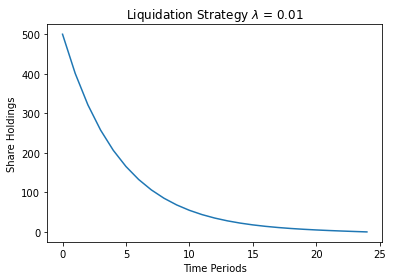

In [14]:
t=np.linspace(0,N,N+1)
plt.plot(t,xk)
plt.title(f"Liquidation Strategy $\lambda$ = {ld}")
plt.xlabel("Time Periods")
plt.ylabel("Share Holdings")
plt.show()

**<u>Remarque</u>** :   
La solution dépend de lambda qui est spécifique au trader et des paramètres du marché.